In [2]:
from os import listdir
from matplotlib import image
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F

from __future__ import print_function
import argparse
import numpy  as np
from PIL import Image
import torchvision
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.model_selection import train_test_split

import numpy as np
import skimage
from skimage import data
import matplotlib.pyplot as plt  
import cv2

In [3]:

# Network architecture.

class Deep_Emotion(nn.Module):
    def __init__(self):
        '''
        Deep_Emotion class contains the network architecture.
        '''
        super(Deep_Emotion,self).__init__()
        self.conv1 = nn.Conv2d(1,10,3)
        self.conv2 = nn.Conv2d(10,10,3)
        self.pool2 = nn.MaxPool2d(2,2)
        
        self.conv3 = nn.Conv2d(10,10,3)
        self.conv4 = nn.Conv2d(10,10,3)
        self.pool4 = nn.MaxPool2d(2,2)

        self.norm = nn.BatchNorm2d(10)

        self.fc1 = nn.Linear(810,50)
        self.fc2 = nn.Linear(50,7)
        
        self.dropout = nn.Dropout(0.3)
        
        self.localization = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )
        self.fc_loc = nn.Sequential(
            nn.Linear(640, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))
        
    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 640)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size(),align_corners=True)
        x = F.grid_sample(x, grid)
        return x
#         return grid

    def forward(self,input):
#         grid = self.stn(input)
        out = self.stn(input)
        
#         out = F.relu(self.conv1(input))
        out = F.relu(self.conv1(out))
        out = self.conv2(out)
        out = F.relu(self.pool2(out))
        
        out = F.relu(self.conv3(out))
        out = self.norm(self.conv4(out))
        out = F.relu(self.pool4(out))

        out = self.dropout(out)
        
#         out = F.grid_sample(out, grid)    #---------------------------->
        
        out = out.view(-1, 810)
        out = F.relu(self.fc1(out))
        out = self.fc2(out)

        return out
print("finish")

finish


In [16]:

device = "cpu"
def funfac(img):
    transformation= transforms.Compose([transforms.ToTensor()])

    net = Deep_Emotion()
    net.load_state_dict(torch.load('C:/Users/nourg/Desktop/4th Year/GP/archive/deep_emotion_ck+-100-64-0.005-97%.pt'))
    net.to(device)
    net.eval()
#Model Evaluation on test data
    classes = ('Angry', 'contempt' ,'Disgust', 'Fear', 'Happy','Sad', 'Surprise')
    
    # gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # cv2.rectangle(img, (x,y), (x+w, y+h), (255,0,0), 2)
    resize_frame = cv2.resize(img, (48, 48))
    plt.imshow(resize_frame)
    plt.show()
    X = resize_frame/256
    X = Image.fromarray((X))
    X = transformation(X).unsqueeze(0)
    
    with torch.no_grad():

        imj = X.to(device)
        out = net(imj)
        pred = F.softmax(out,dim=1)
        classs = torch.argmax(pred,1)

        prediction = classes[classs.item()]
        print(prediction)
    return prediction

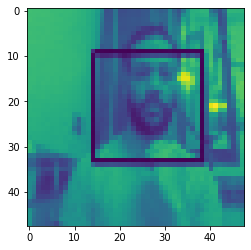

contempt
contempt


In [18]:
img = cv2.imread('C:/Users/nourg/Desktop/4th Year/GP/176080524_313517023516677_5063433350930919366_n.jpg',0)
print(funfac(img))